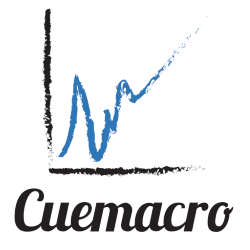

# Real life tcapy case study on an asset manager's trade data

**Saeed Amen / Founder of Cuemacro**

https://www.cuemacro.com / saeed@cuemacro.com / @saeedamenfx / All material is copyright Cuemacro / 2020

Many of the examples we have shown elsewhere use randomized trade/order data. However, in practice, the output of any TCA using randomized trade data is likely to be quite artificial. In this section, we use a real dataset of trade level data during most of 2017 from Swedbank Robur, a Swedish asset manager from their FX trading desk to run some TCA. We'd like to thank Swedbank Robur for allowing us to publish the results. Whilst, we aren't able to provide the raw data to readers (hence, you won't be able to recalculate the results on your own machines), it nevertheless illustrates some of the steps you'll need to take on your own trading data to normalize it, and in particular how you could approach your TCA. If you'd like us to run similar analysis on your firm's execution data, let us know!

In [1]:
# To reduce the logging output run this
import logging
import sys
logging.disable(sys.maxsize)

## Normalization of trade data format

The first step of any sort of analysis of trade data, is to normalize the data. Basically, we need to convert it into a format that tcapy can read easily. tcapy includes a class `DataNorm` which can be used for this (you can extend this to fit your own normalization). In our case, we'll simply normalize the dataset before we even supply it to tcapy.

Some of the steps we need to do:

* Convert fields name to the stand ones for tcapy
    * eg. `create_date_in_est` -> `Date` (and make `Date` index)
* Change certain field contents
    * eg. `EUR.USD` -> `EURUSD`
* Making certain fields confidential for publishing reasons
    * eg. client name
* Only filter for FX spot trades, given that forwards/swaps etc. are not yet supported in tcapy

The precise steps will of course vary depending on your dataset, however once the format you know is defined, you can reuse your normalisation code. Our dataset is in Excel format, which we then saved into CSV format, so once normalized, we'll dump to disk back into CSV format that can be ingested by tcapy.

In [2]:
import pandas as pd

import datetime

csv_trade_data_path = "e:/cuemacro/tcapy/external/trade_2017.csv"
output_csv_trade_data_path = "e:/cuemacro/tcapy/external/trade_2017_output.csv"
linux_csv_trade_data_path = "/home/tcapyuser/cuemacro/tcapy/external/trade_2017_output.csv"

# If not using Celery
# linux_csv_trade_data_path = output_csv_trade_path

df_trades = pd.read_csv(csv_trade_data_path)
df_trades = df_trades[df_trades["type"] == "SPOT"]

The dates are in American date format. The original file was in Excel format, before being converted to CSV. However, Excel has "detected" them as European date. As a result we've ended up with two formats (eg 01/02/2017 05:58:55 mistakenly identified as European date, although the time has been correctly converted and 1/16/2017 3:36:18 AM left as a string by Excel). One check we can do is to make sure that the ordering hasn't been changed, by our date parsing. We write a function that tries parsing dates in two different ways.

In [3]:
def parse_date(d):
    try:
        return datetime.datetime.strptime(d, "%m/%d/%Y %H:%M:%S")
    except:
        return datetime.datetime.strptime(d, "%m/%d/%Y %H:%M:%S %p")

Apply the date parser to the trade date/time column.

In [4]:
df_trades['create_date_in_est'] = df_trades['create_date_in_est'].apply(parse_date)

Remove the empty fields with `user_field`.

In [5]:
df_trades = df_trades.drop(columns=[x for x in df_trades.columns if 'user_field' in x])

Rename the columns so they have the same names that tcapy expects.

In [6]:
df_trades = df_trades.rename(
    columns={"trade_id":"id", "create_date_in_est": "Date", "provider":"broker_id", "ccy_pair":"ticker",
"deal_side":"side",
"dealt_ccy":"notional_currency",
"dealt_amount":"executed_notional",
"spot_rate":"executed_price"
})

Let's look at the columns. Most columns we won't end up using anyway for the TCA calculation later.

In [7]:
df_trades.columns

Index(['id', 'sef', 'voluntary_sef', 'source', 'venue', 'trade_date', 'Date',
       'cust_name', 'client_sef_member', 'autoexec', 'broker_id',
       'prov_sef_member', 'ticker', 'type', 'tenor', 'side',
       'notional_currency', 'executed_notional', 'contra_amount',
       'executed_price', 'fwd_pts', 'all_in', 'mid_rate', 'value_date',
       'fixing_date', 'manual', 'amend_type', 'amend_details', 'amend_status',
       'in_competition', 'send_detail', 'batch_id', 'source_id', 'remarks',
       'leg_usi'],
      dtype='object')

Multiple trades under the same `id` are listed with different `executed_notional` amounts, same time and prices. This suggests that they have just been booked under different accounts. From a TCA perspective, it would make things easier if we could view these as a single execution. So we aggregate each of these groups into 1 trade, and drop duplicates.

In [8]:
df_trades_notionals = df_trades.groupby(['id'])['executed_notional'].sum()
df_trades = df_trades.drop(columns=['executed_notional'])
df_trades = df_trades.join(df_trades_notionals, on='id')
df_trades = df_trades.drop_duplicates(subset='id', keep='first')

The tickers have `.` in them eg. `EUR.USD`, we remove the `.` so it becomes compatible with the tickers in tcapy.

In [9]:
df_trades['ticker'] = df_trades['ticker'].str.replace('.','')

Ok, the tickers look as a expected now

In [10]:
df_trades['ticker'].head(5)

0     EURSEK
6     USDSEK
12    PLNSEK
13    CADSEK
14    GBPSEK
Name: ticker, dtype: object

We set the index as `Date` which is what tcapy expects. Note, tcapy could handle different trades if they happened to be at exactly the same time.

In [11]:
df_trades = df_trades.set_index('Date')
df_trades.index = pd.to_datetime(df_trades.index)

Let's have a look at the first few trades, to see if looks ok.

In [12]:
df_trades.head(2)

,id,sef,voluntary_sef,source,venue,trade_date,cust_name,client_sef_member,autoexec,broker_id,...,amend_type,amend_details,amend_status,in_competition,send_detail,batch_id,source_id,remarks,leg_usi,executed_notional
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02 05:58:55,127379984,N,-,RFQ2,CLASSIC RFQ,20170102,NaN,N,-,1,...,NONE,NaN,NONE,Y,N,0,-,NaN,YCDYZNMZ3J127379984L0,7315000.0
2017-01-02 08:27:24,127384679,N,-,RFQ2,CLASSIC RFQ,20170102,NaN,N,-,2,...,NONE,NaN,NONE,Y,N,0,-,NaN,YCDYZNMZ3J127384679L0,9600000.0


We'll filter some trades which appear to be outliers, because of booking rate.

In [13]:
df_trades = df_trades[(df_trades.broker_id != 13) & (df_trades.index.month != 8) & (df_trades.index.day != 15)]

Finally write to disk.

In [14]:
df_trades.to_csv(output_csv_trade_data_path)

We can query the dataset to see what types of trades there are. As we might expect, there are lots of SEK crosses. Note, that our market database does not have all the currencies in it. However, if we have some of the crosses, tcapy can construct a cross rate benchmark, if we have both USD crosses. tcapy first attempts to check if the pair is in the database, and then will then try constructing a cross. 

We should try to collect market tick data for the crosses we are likely to trade, eg. whilst theoretically we can construct EURSEK via EURUSD and USDSEK, EURSEK is the primary pair for SEK, hence EURSEK data would be better. Note, that we'll only be looking at a small number of the crosses traded. Note, that tcapy can ingest data even if its booked the non-conventional way, eg. SEKEUR etc.

In [15]:
df_trades['ticker'].unique()

array(['EURSEK', 'USDSEK', 'PLNSEK', 'CADSEK', 'GBPSEK', 'USDHKD',
       'JPYSEK', 'ILSSEK', 'EURUSD', 'DKKSEK', 'ZARSEK', 'NOKSEK',
       'AUDSEK', 'CHFSEK', 'USDTRY', 'USDPLN', 'HKDSEK', 'GBPUSD',
       'USDCAD', 'USDJPY', 'EURGBP', 'EURCHF', 'CADJPY', 'SGDSEK',
       'GBPCAD', 'USDZAR', 'AUDCAD', 'TRYSEK', 'CZKSEK', 'EURCAD',
       'USDDKK', 'HUFSEK', 'NZDSEK', 'GBPCHF', 'AUDUSD', 'USDNOK',
       'TRYPLN', 'MXNSEK', 'CNHSEK', 'EURDKK', 'GBPPLN', 'EURPLN',
       'EURTRY', 'EURHKD', 'AUDJPY', 'EURZAR', 'USDSGD'], dtype=object)

## Setting tcapy parameters and doing module imports

We have now prepared our trade data so it is in the right format for tcapy, and dumped it to CSV. Let's define the paths that we'll use. We are assuming that we have tcapy running on Windows, and using WSL/Ubuntu for the backend (and Celery).

In [16]:
import sys
import os

windows_tcapy_path = 'e:/cuemacro/tcapy' # Windows platform
linux_tcapy_path = '/home/tcapyuser/cuemacro/tcapy' # Linux platform
local_test_data_path = 'e:/cuemacro/tcapy/tests_harness_data/' # Windows platform
remote_test_data_path = '/home/tcapyuser/cuemacro/tcapy/tests_harness_data/' # WSL drive

# Assuming the front end is on Windows
sys.path.insert(0, windows_tcapy_path)

# Using data from dukascopy (a free data source)
data_vendor = 'dukascopy'

Let's make a load of imports that we'll need to use later and also setting up of Plotly for plotting.

In [17]:
from collections import OrderedDict

# This is the entry point for our TCA analysis
from tcapy.analysis.tcaengine import TCAEngineImpl

# To construct the parameters for our TCA calculation
from tcapy.analysis.tcarequest import TCARequest

# To access trade and market data
from tcapy.data.databasesource import DatabaseSourceCSVBinary, \
    DatabaseSourceDataFrame, DatabaseSourceDukascopy

# Import all the metrics and benchmarks we'll use
from tcapy.analysis.algos.benchmark import BenchmarkArrival, BenchmarkMarketSpreadToMid
from tcapy.analysis.algos.metric import MetricSlippage, MetricTransientMarketImpact

# To aggregate the TCA results
from tcapy.analysis.algos.resultsform import TimelineResultsForm, DistResultsForm, \
    BarResultsForm, TableResultsForm, ScatterResultsForm, JoinTables

# For filtering initial trades
from tcapy.analysis.tradeorderfilter import TradeOrderFilterTag

# To help display the output of a TCA calculation
from tcapy.vis.tcaresults import TCAResults
from tcapy.vis.report.tcareport import TCAReport
from tcapy.vis.displaylisteners import PlotRender

# General classes
from tcapy.conf.constants import Constants
from tcapy.util.mediator import Mediator

# Prevent requests from displaying debug messages for certain libraries
import logging

logging.getLogger("findatapy").setLevel(logging.WARNING)
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

# For plotting later
import plotly.io as pio

# For interactive plots (but these disappear when we reopen Jupyter)
# pio.renderers.default = "notebook" 

# For static plots, need Orca (but might not work properly on WSL)
# pio.renderers.default = "svg"
pio.renderers.default = "png"

import plotly

# plotly.io.orca.config.executable = '/home/tcapyuser/anaconda3/envs/py36tca/lib/orca_app/orca' # You might need to change this
# plotly.io.orca.config.save()

from chartpy import Chart, Style

# default size for Plotly charts we use
chart_width = 800
chart_height = 500

chart = Chart(engine='plotly')
constants = Constants()
style = Style(width=chart_width, height=chart_height, scale_factor=-1, silent_display=True)

## What is slippage?

Throughout this paper, we will be focusing on using slippage as a way to measure transaction costs for the client.

Slippage is the difference between where we executed and a mid market price at the time or just before our execution which we use for comparison. 

* If slippage is negative, it implies we are doing worse than mid, which is the typical scenario when we are taking liquidity. 
* Hence, if we were buying above the mid, our slippage would be negative (eg. buying at the ask quote). 
* If we were selling below the mid, our slippage would also be negative (eg. selling at the bid quote).

The mid price we use should be independent and aggregated from several liquidity sources (this might require a paid subscription). For simplicity here, we've used a free source though.

There are also many other metrics we can use to understand our execution costs, such as market impact, which is the amount by which the mid moves following our execution.

## Running TCA calculation

We've now done alll the imports, that we'll need for the calculation. Let's define where the CSV file is stored.

In [18]:
local_csv_trade_order_mapping = {'trade_df' : linux_csv_trade_data_path}

The `TCAEngine` class is the entry point for running a TCA calculation.

In [19]:
tca_engine = TCAEngineImpl()

volatile_cache = Mediator.get_volatile_cache()

We now define our `TCARequest` object for our TCA calculation. 

We note that:

* the trade dataset is from CSV and the market data has been downloaded from Dukascopy and dumped to the disk
* for metrics, we are calculating slippage and for benchmarks we are adding a field for the arrival price
* we are calculating aggregated results for
    * timeline of average slippage by date
    * timeline of total amount executed by date in reporting currency (by default USD)
    * timeline of total amount executed by hour of day in London hours
    * timeline of average slippage by hour of day in London hours
    * distribution of slippage by side (buy/sell)
    * average slippage by broker 
    * average slippage by side
    * average slippage by ticker
    * average executed notional per trade by broker
    * total executed notional by broker
* note, that typically these are weighted averages, based on the executed notional (you can choose to weight by other fields though)
* we have multiplied slippage by 10000, to convert it into basis points

In [20]:
ticker = 'EURSEK'

tca_request = TCARequest(start_date='01 Jan 2017', finish_date='08 Nov 2017', ticker=ticker,
    tca_type='detailed',
    trade_data_store='csv', market_data_store='arctic-' + data_vendor,
    trade_order_mapping=local_csv_trade_order_mapping,
    metric_calcs=[MetricSlippage()],
    results_form=[
        # Timeline of slippage (by date)
        TimelineResultsForm(metric_name='slippage', scalar=10000.0),
                             
        # Timeline of sum of executed notional (by date)
        TimelineResultsForm(metric_name='executed_notional_in_reporting_currency', 
                            aggregation_metric='sum', scalar=1.0),
        
        # Timeline of sum of executed notional (by hour of day - LDN)
        TimelineResultsForm(metric_name='executed_notional_in_reporting_currency', 
                            aggregation_metric='sum', scalar=1.0, by_date='hourldn'),
                             
        # Timeline of average slippage by hour of day (in London timezone)
        TimelineResultsForm(metric_name='slippage', scalar=10000.0, by_date='hourldn'),
                             
        # Timeline of sum of executed notional by hour of day (in London timezone)
        TimelineResultsForm(metric_name='executed_notional_in_reporting_currency', 
                            aggregation_metric='sum', scalar=1.0, by_date='hourldn'),
                             
        # Distribution of the slippage by side of trade
        DistResultsForm(metric_name='slippage', aggregate_by_field='side', scalar=10000.0),
                             
        # Aggregate the average slippage on trades/orders by broker_id
        BarResultsForm(metric_name='slippage', aggregate_by_field='broker_id', scalar=10000.0),
                             
        # Aggregate the average slippage on trades/orders by side
        BarResultsForm(metric_name='slippage', aggregate_by_field='side', scalar=10000.0),
                             
        # Aggregate the average slippage on trades/orders by ticker
        BarResultsForm(metric_name='slippage', aggregate_by_field='ticker', scalar=10000.0),
                         
        # Aggregate the average executed notional on trades/orders by broker_id
        BarResultsForm(metric_name='executed_notional_in_reporting_currency', 
                       aggregate_by_field='broker_id',
                       aggregation_metric='mean'),
                             
        # Aggregate the sum executed notional on trades/orders by broker_id
        BarResultsForm(metric_name='executed_notional_in_reporting_currency', 
                       aggregate_by_field='broker_id',
                       aggregation_metric='sum'),
                             
        # Create a scatter plot between executed notional and slippage
        ScatterResultsForm(scatter_fields=['executed_notional', 'slippage'], scalar={'slippage' : 10000.0})
                                                ],
        benchmark_calcs=[BenchmarkArrival(), BenchmarkMarketSpreadToMid()], dummy_market=True,
        use_multithreading=True)

Let's kick off the TCA calculation. The time it takes depends upon how much of the market data has already been cached in Redis.

In [21]:
# Dictionary of (mostly) dataframes as output from TCA calculation
dict_of_df = tca_engine.calculate_tca(tca_request)

AttributeError: 'NoneType' object has no attribute 'columns'

Let's take a look at the output of our TCA calculation which is mixture of DataFrame objects and Plotly Figure objects. There's a lot here! We'll try to go through a few of these tables and charts to explain them.

In [ ]:
dict_of_df.keys()

To make the output easier to understand, we use the `TCAResults` class, and we render all the charts as Plotly Figures (which haven't already been rendered). We also use `TCAReport` to create a PDF to summarize the TCA output. You can view the PDF report on [GitHub](TODO).

In [ ]:
tca_results = TCAResults(dict_of_df, tca_request)
tca_results.render_computation_charts()

tca_report = TCAReport(tca_results)
html_code = tca_report.create_report(output_filename='asset_manager_' + data_vendor + '.pdf', output_format='pdf');

### Plotting market and trade data

Let's see the keys of all the charts with market data for EURSEK and trades which we executed.

In [ ]:
tca_results.sparse_market_charts.keys()

We can plot it directly in Jupyter notebook, given it's a Plotly Figure object. The buy EURSEK trades are in green and sell EURSEK trades are in red. Each trade bubble is proportional to the size of the trade. We see that most of the bubbles are green, showing that on average there were more buy trades. We also see that the largest trade was a buy EURSEK trade in June 2017, as indicated by the largest green bubble on the chart. The dotted green line is the arrival price.

In [ ]:
tca_results.sparse_market_charts['EURSEK_trade_df']

Or we can plot using the `Chart` object from chartpy

In [ ]:
chart.plot(tca_results.sparse_market_charts['EURSEK_trade_df'])

### Plotting timeline charts for slippage and executed notional

We can also view the timeline based charts, which are based on the slippage and total reported currency. Let's see what timeline charts we have calculated during our TCA analysis.

In [ ]:
tca_results.timeline_charts.keys()

Let's plot the mean slippage for our trades bucketed by date and the units on the y-axis are in basis points. There are certain dates where our executions were much better than mid (ie. slippage was positive), in particular in February and September. We also see in January and July, the worst dates for slippage of around -40 basis points worse than mid. In other words, per 1 million of EURSEK transacted (in USD amounts, which we've defined as our reporting currency) on those dates, the slippage was costing us 4000 USD.

In [ ]:
tca_results.timeline_charts['trade_df_slippage_by/mean_date/all']

We can also slice up our slippage by time of day, which involves taking an average of each hour and minute of the date where we have trades. We need to be careful with this sort of analysis, given by the time we've sliced and diced the data, each point is likely to have a relatively small number of samples. Here, we're looking at the data in London time. The units on the y-axis are in basis points. On the x-axis, we have the hour of day in London time. So for example 5 would represent the hour between 0500-05:59:59.999 in LDN time.

It can make it easier looking at it in London time or say New York time. If we look at time of day data in UTC time, it can be confusing because scheduled data points (eg. Riksbanks meetings), can shift during summer time, making it more difficult to understand price action around them.

We see that generally that on average during the hour of 0500-05:59:59.999 LDN the slippage is the worst around -7 basis points (ie. 7 basis points worse than mid). By constrast trades done much earlier or much later in London hours the slippage appears to be around +10 basis points better than mid. Does that necessarily mean we should execute later in the day or very early in the morning? Not necessarily as we'll see next.

In [ ]:
tca_results.timeline_charts['trade_df_slippage_by/mean_hourldn/all']

How much did we execute by hour of day in London hours? We see that we executed very little towards very early between 1200-1300 LDN or at 0200-0300 LDN (it's very close to zero). One of the explanations that the slippage in these hours was so "good" was basically because we executed so little, rather than these being the hours of day as being best for execution. In particular for 0200-0300 LDN it is unlikely that there'd be much activity in EURSEK, given the market hours for Sweden.

In terms of hours of the day, the largest total amount was executed during the hour between 1100-1200 LDN around 475mm USD in total during our sample through 2017.

In [ ]:
tca_results.timeline_charts['trade_df_executed_notional_in_reporting_currency_by/sum_hourldn/all']

### Plotting distribution charts for slippage by side

We can plot the distribution of slippage, to understand if our results are being skewed by any particular outliers.

In [ ]:
tca_results.dist_charts.keys()

Let's plot the distribution of the slippage. The y-axis gives the notional in the reporting currency (which we've defined as USD). The x-axis shows the slippage in basis point. Negative slippage implies that we are doing worse than mid (which is likely the typical scenario if we're taking liquidity, ie. having to sell at the bid and buying at the ask). Positive slippage implies that we're actually doing better than the mid. In this case, as elsewhere, ideally the mid price we use as a reference should be based on several liquidity providers.

In this case, we see the sell trades (in red) have the slippage are negatively skewed to the left (the peak of the red lines are in negative territory), whilst the buy trades (in green) are skewed positively to the right (the peaks of the green lines are in positive territory). Later, we'll see that on average the slippage was negative for sell EURSEK, but was positive for buying EURSEK for the client, which tallies with this distribution chart.

In [ ]:
tca_results.dist_charts['trade_df_slippage_by/pdf/side']

### Plotting bar charts for average slippage and executed notional by broker

We can plot the bar charts which aggregate the various statistics, such as slippage and total notional executed. First, we get all the keys of the bar charts. Then, we plot the average slippage by broker.

In [ ]:
tca_results.bar_charts.keys()

The y-axis is the average slippage in basis point for our executed trades. The x-axis gives the liquidity providers anonymized codes. We see that for brokers `2`, `8`, `10` and `13`, the slippage is positive, ie. the client is doing better than mid when executing here. By constrast, for most other brokers the slippage is negative, ie. we're paying for liquidity there.

For `broker_id` of `9`, the slippage is most negative, suggesting that the executions are most costly with this broker and requires more investigation and perhaps a discussion with the broker to understand why we appear to be paying higher transaction costs with them compared with any other liquidity provider.

In [ ]:
tca_results.bar_charts['trade_df_slippage_by/mean/broker_id']

Just knowing the slippage in isolation isn't giving us the full picture, as generally large trade sizes will have more slippage. Furthermore the relationship isn't linear. Hence, we now plot the average trade side and the total amount executed per broker.

We see that the client has the largest average executed trade size is with liquidity provider with `broker_id` of `2`. By contrast, we see that only very small trades are being transacted with liquidity provider `12`. The amounts are in USD millions.

In [ ]:
tca_results.bar_charts['trade_df_executed_notional_in_reporting_currency_by/mean/broker_id']

In terms of the total amount executed with each liquidity provider, we see that the most notional transacted was with liquidity provider number `5`, at nearly 450mm USD. For broker `2`, the amount executed during this sample in total is 250mm USD.

In [ ]:
tca_results.bar_charts['trade_df_executed_notional_in_reporting_currency_by/sum/broker_id']

Lastly, we plot the average slippage by side of the trade, to understand whether we have done better on buys or sells. We see that on average, the slippage on selling EURSEK (lablled as -1 on the x-axis) is around -5 basis points (compared to the mid price). In other words, we are paying 5 basis point on average per EURSEK trade in terms of slippage costs.

This contrasts to buying EURSEK (labelled as +1 on the x-axis), where the slippage for the client is around +1.5 basis points. So when the client buys EURSEK, the client is actually doing better than mid. One possible explanation is that liquidity providers for the client were on average long EURSEK in their inventory during this sample period. Hence, they may skew their spread to encourage buyers of EURSEK to flatten their exposure.

In [ ]:
tca_results.bar_charts['trade_df_slippage_by/mean/side']

### Plotting scatter charts for slippage vs. executed notional

Here we plot the executed notional (on x-axis) vs slippage (in basis points and on y-axis).

In [ ]:
tca_results.scatter_charts.keys()

In [ ]:
tca_results.scatter_charts['trade_df_executed_notional_vs_slippage']

## Digging down into TCA for a specific liquidity provider

Here we'll focus on trades done with broker `2`, where slippage is positive (ie. we've on average dealt at a better rate than mid) and also have executed a large amount in size. This seems like an unusual result. Is it consistent behaviour, or because of a small number of trades? We can use the `TradeOrderFilterTag` to filter the trades by the `broker_id` field. Note, that it can be used to filter whatever field we want. 

There are other classes which extend `TradeOrderFilter`, such as `TradeOrderFilterTimeOfDayWeekMonth` which lets us filter the trades by many parameters like:

* day of week, month of year, time of day
* around specific dates (eg. could examine payrolls dates)

In [ ]:
tca_request.trade_order_filter = TradeOrderFilterTag(tag_value_combinations={'broker_id' : '2'})

# Dictionary of (mostly) dataframes as output from TCA calculation
dict_of_df = tca_engine.calculate_tca(tca_request)

tca_results = TCAResults(dict_of_df, tca_request)
tca_results.render_computation_charts()

Let's look at the output of the TCA calculation.

In [ ]:
print(dict_of_df.keys())

We can plot the average slippage by time with broker `2`. Alongside it, we also the plot the amount of executed notional in reporting currency we've executed with the broker `2`. The peak in September is just above +40 basis points, showing we execute much better than mid on trades that day.

In [ ]:
tca_results.timeline_charts['trade_df_slippage_by/mean_date/all']

Let's also show the total amount executed (in USD millions) by date with this broker `2`. We can see that most days, we execute well under 20mm USD. In summer, we see a day when we executed over 100mm USD with this specific broker `2`.

In [ ]:
tca_results.timeline_charts['trade_df_executed_notional_in_reporting_currency_by/sum_date/all']

Let's plot the trades we've executed with liquidity provider `2` only, excluding all the other liquidity providers, alongside the market data for EURSEK spot. We see that we did a big buy trade in EURSEK with this broker in June 2017, as evidenced by the large green bubble then.

In [ ]:
tca_results.sparse_market_charts['EURSEK_trade_df']

We can also plot the distribution of the trades we've done only with `broker_id` of `2`. We see the distribution of the slippage of the sell EURSEK trades in red, and buy EURSEK trades in green.

We see that for the buy trades, slippage is skewed in our favour, unlike the sell trades. We dug down into the trades further above, and the large trade in June, which we flagged above, was a buy trade, where we bought slightly below the mid. Hence, it does indeed appear that a single trade has skewed our result. We could simply exclude this trade from our analysis to confirm this.

In [ ]:
tca_results.dist_charts['trade_df_slippage_by/pdf/side']

Here are all the bar charts which have been generated, which we could also plot with analysis too.

In [ ]:
tca_results.bar_charts.keys()

## Run for multiple crosses

We might wish to run our analysis for multiple tickers, to compare metrics between them. As we did before, we run the TCA output through the `TCAResults` object to simplify it.

In [ ]:
tca_request.trade_order_filter = None
tca_request.ticker = ['EURSEK', 'USDSEK', 'GBPSEK']
tca_request.tca_type = 'aggregated'
tca_request.summary_display = 'candlestick'

tca_request.results_form = [
    # Timeline of slippage
    TimelineResultsForm(metric_name='slippage', aggregate_by_field='ticker', scalar=10000.0),
                             
    # Distribution of the slippage by side of trade
    DistResultsForm(metric_name='slippage', aggregate_by_field='ticker', scalar=10000.0),
                            
    # Aggregate the average slippage on trades/orders by broker_id
    BarResultsForm(metric_name='slippage', aggregate_by_field='broker_id', scalar=10000.0),
                             
    # Aggregate the average slippage on trades/orders by broker_id
    BarResultsForm(metric_name='slippage', aggregate_by_field='ticker', scalar=10000.0),
                         
    # Aggregate the average slippage on trades/orders by broker_id
    BarResultsForm(metric_name='executed_notional_in_reporting_currency', 
                   aggregate_by_field='broker_id',
                   aggregation_metric='mean'),
                            
    # Create a scatter plot between executed notional and slippage
    ScatterResultsForm(scatter_fields=['executed_notional', 'slippage'], scalar={'slippage' : 10000.0})
]

# Dictionary of (mostly) dataframes as output from TCA calculation
dict_of_df = tca_engine.calculate_tca(tca_request)

tca_results = TCAResults(dict_of_df, tca_request)
tca_results.render_computation_charts()

Let's view the output DataFrames and Figures.

In [ ]:
dict_of_df.keys()

### Average slippage by ticker

We can compare the average slippage by ticker in our sample, which we plot before. The y-axis shows the avearge slippage in basis points. Again note that a negative slippage means that we are executing worse than mid, which is what we'd generally expect if we're taking liquidity. We see that USDSEK has a much large amount of slippage (around -8 basis points from the client perspective) compared to EURSEK (slightly less than -2 basis points). We would expect this, given EURSEK is a much more liquid pair than USDSEK.

In [ ]:
tca_results.bar_charts.keys()

In [ ]:
tca_results.bar_charts['trade_df_slippage_by/mean/ticker']

### Distribution of slippage by ticker

We can also compare the distribution of the slippage by ticker. The y-axis shows the notional executed in reporting currency (USD) and the x-axis is the slippage in basis points. Again we see how USDSEK is more heavily skewed to the left in terms of slippage, more negatively skewed.

In [ ]:
tca_results.dist_charts.keys()

In [ ]:
tca_results.dist_charts['trade_df_slippage_by/pdf/ticker']

### Plotting trades vs market data

We can look at the USDSEK trades alongside market data.. Let's check what the keys are for these market/trade plots and then plot the Plotly Figure object for USDSEK. We can see that most of the flow is for buying USDSEK, with a very small number of (large) exceptions, where they are selling, like in June 2017 (the large red bubble).

In [ ]:
tca_results.sparse_market_charts.keys()

In [ ]:
tca_results.sparse_market_charts['USDSEK_trade_df']

# Conclusion

We have seen how to run tcapy on a real dataset from a Swedish asset manager. We have looked at how we can create relatively elaborate queries for our TCA analysis to calculate statistics such as:

* the slippage by time of day
* the average slippage by broker or ticker
* the PDF of the slippage

Furthermore, we have illustrated our analysis through the use of visualisations generated by tcapy, which are in Plotly Figure form. These can be quickly displayed, with minimal work by users. Whilst, we have focused on looking at slippage, we can also calculate other metrics such as market impact and also markouts. In the future, we are planning to develop market impact models and other more complex metrics. 

We also explained the meaning of the various charts, and how they could allow us to compare the liquidity from various brokers, to understand how our trading costs differed between them.

If you are interested in supporting the tcapy project, please contact saeed@cuemacro.com to help us add new features and improve the library. Or if you'd like us to do a research study on your firm's trade data, please do also get in contact.